# Installing bnlp toolkit and bnltk library

In [ ]:
pip install bnlp_toolkit

In [ ]:
pip install bnltk

In [ ]:
pip install -U bnlp_toolkit

# Importing Library

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bnlp.corpus import stopwords
from bnlp.corpus.util import remove_stopwords

from bnltk.stemmer import BanglaStemmer
from pandas import read_excel
import re
from re import sub
import multiprocessing

import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Read dataset

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')
dataset=pd.read_csv('/content/Covid Vaccine data(3807).csv')


In [ ]:
dataset.shape

(3807, 2)

Non-urgent: 180000.00%, Urgent: 200700.00%


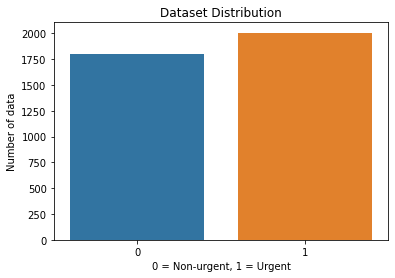

In [ ]:
target_vc = dataset["Polarity"].value_counts(normalize=False)
print("Non-urgent: {:.2%}, Urgent: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Dataset Distribution")
plt.xlabel("0 = Non-urgent, 1 = Urgent")
plt.ylabel("Number of data")
plt.show()

# Data Preprocessing

In [ ]:
import re
corpus=[]
max=0
for i in range(0,len(dataset)):
    review = re.sub('[\!"#$%&()*,./:;<=>?@[\\]^`{|}~\t\n।+-]', ' ', dataset['Text'][i])
    review=review.replace('_',' ')
    #review=review.replace('ঃ',' ')
    #review = re.sub('[a-zA-Z0-9]+', ' ', review)    
    review = re.sub('[''````£|¢|/=।!“’<>‘॥”‰\'🤓⌚🤰🥺⚽️✌�￰🥀🤣🤡🤗🤐🤦🤔⏩⏹￰]', ' ', review)               
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations 
                           u"\\U0001f90f" 
                           u"\\U0001f9cf"
                           u"\U0001fa78"  
                           "]+", flags=re.UNICODE)
    review=emoji_pattern.sub(r'', review)
    #review=str(review)
    #review=review.split()
    '''review=review.replace('A', 'এ')
    review=review.replace('B', 'বি')
    review=review.replace('AB', 'এবি')
    review=review.replace('O', 'ও')
    review=review.replace('+','পজিটিভ')
    review=review.replace('-','নেগেটিভ')'''
    review=review.lower()
    #bn_stemmer = BanglaStemmer()
    #review=bn_stemmer.stem(review)
    #review = remove_stopwords(review, stopwords)
    review=str(review)
    review=review.split()
    review=' '.join(review)
    corpus.append(review)
    if(max<len(review)):
      max=len(review)
print(max)


502


In [ ]:
corpus

['আমাদের সজাগ থাকতে হবে টিকা নেওয়া নিয়ে',
 'ভ্যাকসিন ভালো না',
 'আমার পরিবারের সকলেই টিকা নিয়েছে',
 'টিকা লক্ষণীয় রোগ প্রতিরোধে একইভাবে উচ্চ কার্যকারিতা রয়েছে',
 'অনলাইনে আবেদন করে আমি ভ্যাকসিন নিয়েছি',
 'নিজে সচেতন হই এবং অন্যকে সচেতন হতে সাহায্য করি সবাই মাস্ক ব্যবহার করি আল্লাহ আমাদের সহায় হওক অন্যদের টিকা গ্রহণে উৎসাহিত করুন আমিন',
 'আমাদের সতর্ক থাকতে হবে টিকা প্রদান নিয়ে অনেক টিকা শরীরের ক্ষতিও করে',
 'টিকা নিয়ে যদি অসুস্থ হয়ে পরি তখন আমার বাচ্চাদের খাওয়াবে কে আপনি',
 'গনটিকা প্রদানের যে পরকিল্পনা গ্রহণ করা হয়েছে সেটি সাধুবাদযোগ্য',
 'আমার দ্বিতীয় ডোজ দেয়া হয়েছে এখন বুস্টার ডোজ নিতে চাই',
 'আমার বয়স ৯০ আমি টিকা নিয়েছি',
 'নির্ভয়ে টিকা নিয়ে নির্ভয়ে এখন বেঁচে আছি',
 'টিকা নেওয়ার আগে অনেকে বলেছে ১০ থেকে ১৫ মিনিট মাথা ঘুরতে পারে এটা সত্যি',
 'গর্ভবতীরা টিকা নিলে বিপদ আছে',
 'ভেক্সিন নিলে সংক্রমণের মাত্রা অনেকটা কম হবে নাকি আরও বেড়ে যেতে পারে সেটা আগে সরকারকে আমাদের বুঝাতে হবে',
 'এই যুগে বেঁচে থাকার প্রথম শর্ত হলো হলো ভ্যাকসিন',
 'ভেকসিন নিলে মানসিক ক্ষতি হয়',
 'ওরে বাঙ্গাল

# Feature Selection(TF-IDF)



In [ ]:
# TF-IDF process
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(ngram_range = (1,2))
X= cv.fit_transform(corpus).toarray()
y= dataset.iloc[:, 1].values
#print(X)
#print(y)

#SVM with 80:20 spliting

In [ ]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=0)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Fitting SVC to the training set
from sklearn.svm import SVC
classifier=SVC(kernel='linear',random_state=0)
classifier.fit(X_train, y_train)



SVC(kernel='linear', random_state=0)

In [ ]:
#predicting the Test set results
y_pred=classifier.predict(X_test)




Confusion Matrix for PassiveAggressiveClassifier


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f251b51cd50>)

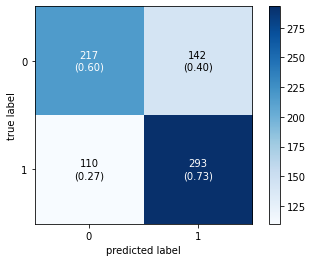

In [ ]:
#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [ ]:
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)


Accuracy 0.669
precision 0.674
Recall 0.727
f1_score 0.699


# SVM with 10-fold cross validation

In [ ]:
#Applying 10-fold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True,random_state=0)
# evaluate model
from sklearn.svm import SVC
classifier=SVC(kernel='linear',random_state=0)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('Accuracy %.3f'%mean(scores))
print('precision %.3f'%np.mean(precision))
print('Recall %.3f'%np.mean(recall))
print('f1_score %.3f'%np.mean(f1))

Accuracy 0.687
precision 0.692
Recall 0.732
f1_score 0.711


# Decision Tree with 80:20 spliting

In [ ]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Fitting Decision Tree to the training set
training_accuracy = []
test_accuracy = []
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion="entropy", random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Confusion Matrix for PassiveAggressiveClassifier


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f251b3a5fd0>)

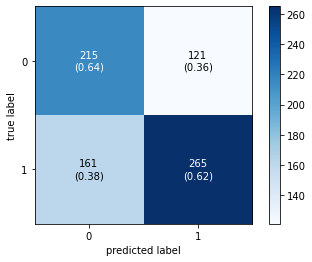

In [ ]:
#predicting the Test set results
y_pred=classifier.predict(X_test)


#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [ ]:
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy) 

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)


from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)


Accuracy 0.630
precision 0.687
Recall 0.622
f1_score 0.653


# Decision Tree with 10-fold cross validation

In [ ]:
#Applying 10-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True, random_state=0)
# evaluate model
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion="entropy", random_state=0)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.646
0.675
0.635
0.654


# Naive Bayes with 80:20 spliting

In [ ]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion Matrix for PassiveAggressiveClassifier
Accuracy 0.530
precision 0.758
Recall 0.235
f1_score 0.358


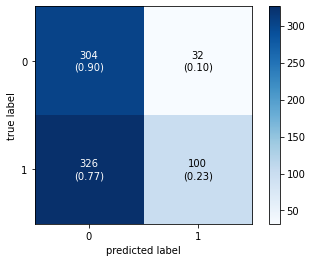

In [ ]:
# Fitting SVC to the training set
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
classifier.fit(X_train, y_train)
#predicting the Test set results
y_pred=classifier.predict(X_test)
#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)

# Naive Bayes with 10-fold cross validation

In [ ]:
#Applying 10-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True, random_state=0)
# evaluate model
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.540
0.755
0.188
0.300


# Random Forest with 80:20 spliting

In [ ]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=0)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion Matrix for PassiveAggressiveClassifier
Accuracy 0.657
precision 0.711
Recall 0.593
f1_score 0.647


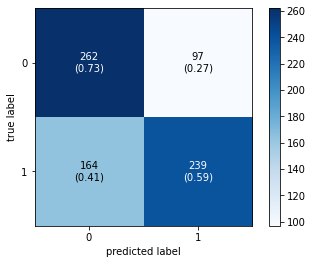

In [ ]:
# Fitting Random Forest to the training set
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
classifier.fit(X_train, y_train)

#predicting the Test set results
y_pred=classifier.predict(X_test)
#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
print("Confusion Matrix for PassiveAggressiveClassifier")
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)

# Random Forest with 10-fold cross validation

In [ ]:
#Applying 10-fold cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import *
# prepare the cross-validation procedure
cv = KFold(n_splits=10,shuffle=True, random_state=0)
# evaluate model
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(classifier, X, y, scoring='recall', cv=cv)
precision = cross_val_score(classifier, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(classifier, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.689
0.728
0.655
0.689


# Adaboost with 80:20 spliting

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [ ]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100,
                         learning_rate=0.1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('%.3f'%accuracy)

#finding precision
from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('%.3f'%precision)

#finding Recall
from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('%.3f'%recall)

#finding f1_score
from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('%.3f'%f1)

0.613
0.582
0.909
0.709


# Adaboost with 10-fold cross validation

In [ ]:
#10-fold cross validation
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import KFold
from statistics import *

model = AdaBoostClassifier(n_estimators=100,learning_rate=0.1)
# evaluate the model
cv = KFold(n_splits=10, random_state=0,shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(model, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.639
0.641
0.741
0.683


# Gradient Boosting With 80:20 Spliting

In [ ]:
# Load libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [ ]:
# Create gradientBoost classifer 
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1)
# Train gradientBoost Classifer
model = gbc.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = model.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
#finding accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
print('Accuracy %.3f'%accuracy)

#finding precision
from sklearn.metrics import precision_score
precision=precision_score(y_test,y_pred,average="binary")
print('precision %.3f'%precision)

#finding Recall
from sklearn.metrics import recall_score
recall=recall_score(y_test,y_pred,average="binary")
print('Recall %.3f'%recall)

#finding f1_score
from sklearn.metrics import f1_score
f1=f1_score(y_test,y_pred,average="binary")
print('f1_score %.3f'%f1)

Accuracy 0.678
precision 0.711
Recall 0.685
f1_score 0.698


# Gradient Boosting With 10-fold cross validation

In [ ]:
#10-fold cross validation
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import KFold
from statistics import *

model = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1)
# evaluate the model
cv = KFold(n_splits=10, random_state=0,shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv)
f1 = cross_val_score(model, X, y, scoring='f1', cv=cv)
# report performance
print('%.3f'%mean(scores))
print('%.3f'%np.mean(precision))
print('%.3f'%np.mean(recall))
print('%.3f'%np.mean(f1))

0.684
0.696
0.718
0.706
